In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from pathlib import Path  
import datetime
from prophet import Prophet


/Users/malefica/opt/anaconda3/envs/boolean/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


IMPORT ALL CSV IN DATAFRAME

In [2]:
oiv_africa = pd.read_excel('oiv_dataset/data_oiv_africa.xlsx')

In [3]:
oiv_america = pd.read_excel('oiv_dataset/data_oiv_america.xlsx')

In [4]:
oiv_asia = pd.read_excel('oiv_dataset/data_oiv_asia.xlsx')

In [5]:
oiv_europe = pd.read_excel('oiv_dataset/data_oiv_europe.xlsx')

In [6]:
oiv_global = pd.read_excel('oiv_dataset/data_oiv_global.xlsx')

In [7]:
oiv_oceania = pd.read_excel('oiv_dataset/data_oiv_oceania.xlsx')

MERGE CSV RELATED CONTINENTS 

In [8]:
oiv = pd.concat([oiv_africa, oiv_america, oiv_asia, oiv_europe, oiv_oceania], ignore_index=True)

In [9]:
#check if are null values
oiv.isnull().sum()

Continent          0
Region/Country     0
Product            0
Variable           0
Year               0
Unit               0
Sum of Quantity    0
dtype: int64

In [10]:
oiv.sample(5)

,Continent,Region/Country,Product,Variable,Year,Unit,Sum of Quantity
47909,Europe,Russia,Wine,Imports,1999,1000 hl,1128
12623,America,Bolivia,Dried Grapes,Consumption,2007,tonnes,200
35485,Asia,Uzbekistan,Wine,Exports,2021,1000 hl,62
7931,Africa,Burundi,Wine,Imports,2013,1000 hl,4
38211,Europe,Finland,Fresh Grapes,Exports,2005,tonnes,100


In [11]:
oiv = oiv.rename(columns={"Region/Country": "Country", "Sum of Quantity": "Quantity"})

In [12]:
#get only 'wine' Product value
oiv_wine = oiv[oiv.Product == 'Wine']

In [13]:
oiv_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17003 entries, 7443 to 51415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  17003 non-null  object
 1   Country    17003 non-null  object
 2   Product    17003 non-null  object
 3   Variable   17003 non-null  object
 4   Year       17003 non-null  int64 
 5   Unit       17003 non-null  object
 6   Quantity   17003 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


In [14]:
oiv_global = oiv_global.rename(columns={"Region/Country": "Country", "Sum of Quantity": "Global_Quantity"})

In [15]:
oiv_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Continent        378 non-null    object
 1   Country          378 non-null    object
 2   Product          378 non-null    object
 3   Variable         378 non-null    object
 4   Year             378 non-null    int64 
 5   Unit             378 non-null    object
 6   Global_Quantity  378 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 20.8+ KB


In [16]:
#add global value to dataframe
oiv_wine = oiv_wine.merge(oiv_global[['Product', 'Year', 'Variable', 'Global_Quantity']],on=['Product', 'Year', 'Variable'], how='inner')

In [17]:
oiv_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17003 entries, 0 to 17002
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Continent        17003 non-null  object
 1   Country          17003 non-null  object
 2   Product          17003 non-null  object
 3   Variable         17003 non-null  object
 4   Year             17003 non-null  int64 
 5   Unit             17003 non-null  object
 6   Quantity         17003 non-null  int64 
 7   Global_Quantity  17003 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 1.2+ MB


In [18]:
filepath = Path('oiv_dataset/oiv_wine.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
oiv_wine.to_csv(filepath)  

In [19]:
oiv_wine["Percent_of_global"] = round(oiv_wine.Quantity / oiv_wine.Global_Quantity, 2)

In [20]:
oiv_wine.sample(5)

,Continent,Country,Product,Variable,Year,Unit,Quantity,Global_Quantity,Percent_of_global
12524,Africa,Congo,Wine,Consumption,2015,1000 hl,32,241826,0.00
10697,America,Montserrat,Wine,Consumption,2012,1000 hl,0,244923,0.00
15682,Europe,Romania,Wine,Production,2019,1000 hl,3808,258194,0.01
16014,Europe,Denmark,Wine,Exports,2020,1000 hl,299,106535,0.00
16137,America,Saint Lucia,Wine,Imports,2020,1000 hl,22,105158,0.00


CONSUMPTION ANALYSIS

In [21]:
oiv_wine_cons = oiv_wine[oiv_wine['Variable'] == 'Consumption' ]

In [22]:
oiv_wine_cons.head()

,Continent,Country,Product,Variable,Year,Unit,Quantity,Global_Quantity,Percent_of_global
0,Africa,Algeria,Wine,Consumption,1995,1000 hl,243,227425,0.0
1,Africa,Angola,Wine,Consumption,1995,1000 hl,255,227425,0.0
2,Africa,Benin,Wine,Consumption,1995,1000 hl,15,227425,0.0
3,Africa,Botswana,Wine,Consumption,1995,1000 hl,18,227425,0.0
4,Africa,Burkina Faso,Wine,Consumption,1995,1000 hl,6,227425,0.0


In [23]:
years = oiv_wine_cons['Year'].unique()

best_cons = pd.DataFrame(columns=['Country','Year','Quantity', 'Percent_of_global'])

i = 3
for year in years:
    bp = ((oiv_wine_cons[oiv_wine_cons['Year'] == year ]).sort_values(by=['Quantity'], ascending = False)[['Country', 'Year', 'Quantity', 'Percent_of_global']].head(i))
    frames = [best_cons, bp]
    best_cons = pd.concat(frames)

In [24]:
best_cons.head(15)

,Country,Year,Quantity,Percent_of_global
150,France,1995,36515,0.16
156,Italy,1995,35623,0.16
90,United States of America,1995,21765,0.1
770,France,1996,34795,0.16
776,Italy,1996,34693,0.16
710,United States of America,1996,20463,0.09
1390,France,1997,35500,0.16
1396,Italy,1997,30855,0.14
1330,United States of America,1997,20800,0.09
2009,France,1998,36330,0.16


In [25]:
#best consumption over all years
oiv_wine_cons.groupby('Country').sum().sort_values('Quantity', ascending = False).head(10)

,Year,Quantity,Global_Quantity,Percent_of_global
Country,,,,
France,54216,832231,6405968,3.53
United States of America,54216,729729,6405968,3.05
Italy,54216,708290,6405968,2.99
Germany,54216,537625,6405968,2.20
China,54216,368157,6405968,1.54
Spain,54216,328408,6405968,1.39
United Kingdom,54216,316037,6405968,1.30
Argentina,54216,293371,6405968,1.25
Russia,54216,244933,6405968,1.00


In [26]:
cons_tmp = (oiv_wine_cons.groupby('Country').sum().sort_values('Quantity', ascending = False)).drop('Percent_of_global', axis=1)
cons_tmp['Percente_of_global'] = round(cons_tmp['Quantity']/cons_tmp['Global_Quantity'], 2)
cons_tmp.head()

,Year,Quantity,Global_Quantity,Percente_of_global
Country,,,,
France,54216,832231,6405968,0.13
United States of America,54216,729729,6405968,0.11
Italy,54216,708290,6405968,0.11
Germany,54216,537625,6405968,0.08
China,54216,368157,6405968,0.06


PRODUCTION ANALYSIS

In [27]:
oiv_wine_prod = oiv_wine[oiv_wine['Variable'] == 'Production' ]

In [28]:
years = oiv_wine_prod['Year'].unique()

best_prod = pd.DataFrame(columns=['Country','Year','Quantity', 'Percent_of_global'])

i = 3
for year in years:
    bp = ((oiv_wine_prod[oiv_wine_prod['Year'] == year ]).sort_values(by=['Quantity'], ascending = False)[['Country', 'Year', 'Quantity', 'Percent_of_global']].head(i))
    frames = [best_prod, bp]
    best_prod = pd.concat(frames)

In [29]:
best_prod.head()

,Country,Year,Quantity,Percent_of_global
602,Italy,1995,55702,0.22
598,France,1995,54354,0.22
614,Spain,1995,20876,0.08
1222,Italy,1996,58772,0.22
1218,France,1996,57047,0.21


In [30]:
#best production over all years
prod_tmp = (oiv_wine_prod.groupby('Country').sum().sort_values('Quantity', ascending = False)).drop('Percent_of_global', axis=1)

In [31]:
prod_tmp['Percente_of_global'] = round(prod_tmp['Quantity']/prod_tmp['Global_Quantity'], 2)

In [32]:
prod_tmp.head()

,Year,Quantity,Global_Quantity,Percente_of_global
Country,,,,
Italy,56238,1385112,7525519,0.18
France,56238,1356045,7525519,0.18
Spain,56238,1005383,7525519,0.13
United States of America,56238,610552,7525519,0.08
Argentina,56238,383966,7525519,0.05


IMPORT ANALYSIS

In [33]:
oiv_wine_imp = oiv_wine[oiv_wine['Variable'] == 'Imports' ]

In [34]:
years = oiv_wine_imp['Year'].unique()

best_imp = pd.DataFrame(columns=['Country','Year','Quantity'])

#change i variable to get 'i' the better states for year
i = 3
for year in years:
    bp = ((oiv_wine_imp[oiv_wine_imp['Year'] == year ]).sort_values(by=['Quantity'], ascending = False)[['Country', 'Year', 'Quantity']].head(i))
    frames = [best_imp, bp]
    best_imp = pd.concat(frames)

In [35]:
best_imp.head(5)

,Country,Year,Quantity
509,Germany,1995,8771
534,United Kingdom,1995,7357
508,France,1995,6127
1129,Germany,1996,10719
1154,United Kingdom,1996,7461


In [36]:
#best import over all years
imp_tmp = (oiv_wine_imp.groupby('Country').sum().sort_values('Quantity', ascending = False)).drop('Percent_of_global', axis=1)
imp_tmp['Percente_of_global'] = round(imp_tmp['Quantity']/imp_tmp['Global_Quantity'], 2)
imp_tmp.head(15)

,Year,Quantity,Global_Quantity,Percente_of_global
Country,,,,
Germany,54216,361051,2258553,0.16
United Kingdom,54216,316309,2258553,0.14
United States of America,54216,223634,2258553,0.10
France,54216,163383,2258553,0.07
Russia,54216,111925,2258553,0.05
Netherlands,54216,97077,2258553,0.04
Canada,54216,85166,2258553,0.04
China,54216,68701,2258553,0.03
Belgium,54216,63691,2258553,0.03


EXPORT ANALYSIS

In [37]:
oiv_wine_cons['Year'].unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021])

In [38]:
oiv_wine_exp = oiv_wine[oiv_wine['Variable'] == 'Exports' ]

In [39]:
years = oiv_wine_exp['Year'].unique()

best_exp = pd.DataFrame(columns=['Country','Year','Quantity'])

i = 3
for year in years:
    bp = ((oiv_wine_exp[oiv_wine_exp['Year'] == year ]).sort_values(by=['Quantity'], ascending = False)[['Country', 'Year', 'Quantity']].head(i))
    frames = [best_exp, bp]
    best_exp = pd.concat(frames)

In [40]:
best_exp.head(5)

,Country,Year,Quantity
326,Italy,1995,15832
320,France,1995,11478
341,Spain,1995,6260
946,Italy,1996,13415
940,France,1996,12990


In [41]:
#best import over all years
exp_tmp = (oiv_wine_exp.groupby('Country').sum().sort_values('Quantity', ascending = False)).drop('Percent_of_global', axis=1)
exp_tmp['Percente_of_global'] = round(exp_tmp['Quantity']/exp_tmp['Global_Quantity'], 2)
exp_tmp.head(15)

,Year,Quantity,Global_Quantity,Percente_of_global
Country,,,,
Italy,54216,492075,2341692,0.21
Spain,54216,430573,2341692,0.18
France,54216,389263,2341692,0.17
Australia,54216,158538,2341692,0.07
Chile,54216,155564,2341692,0.07
South Africa,54216,91964,2341692,0.04
United States of America,54216,91384,2341692,0.04
Germany,54216,86924,2341692,0.04
Portugal,54216,72768,2341692,0.03


percentage of wine exported compared to production

In [42]:
oiv_wine.sample(5)
tmp_exp = oiv_wine.groupby(['Country','Variable'])[['Quantity','Global_Quantity']].agg({'Quantity':'sum', 'Global_Quantity':'sum'}).reset_index()  

In [43]:
tmp_exp.head()

,Country,Variable,Quantity,Global_Quantity
0,Afghanistan,Consumption,39,6405968
1,Afghanistan,Imports,38,2258553
2,Afghanistan,Production,0,1872132
3,Albania,Consumption,5205,6405968
4,Albania,Exports,0,2341692


In [44]:
#tmp_exp['exp_on_prod'] = 

OTHER STATISTICS

In [45]:
oiv_wine.sample(5)

,Continent,Country,Product,Variable,Year,Unit,Quantity,Global_Quantity,Percent_of_global
4664,Europe,Latvia,Wine,Exports,2002,1000 hl,28,67899,0.0
12855,Europe,Romania,Wine,Exports,2015,1000 hl,139,105994,0.0
12894,Africa,Libya,Wine,Imports,2015,1000 hl,1,105162,0.0
5778,Africa,Central African Republic,Wine,Exports,2004,1000 hl,0,76620,0.0
5323,Africa,Eswatini,Wine,Imports,2003,1000 hl,3,68951,0.0


In [46]:
oiv_wine_cons_stat = oiv_wine_cons

In [47]:
oiv_wine_prod_stat = oiv_wine_prod

In [48]:
oiv_wine_exp_stat = oiv_wine_exp

In [49]:
oiv_wine_imp_stat = oiv_wine_imp

In [50]:
oiv_wine_cons_stat = oiv_wine_cons_stat.drop(['Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)

In [51]:
oiv_wine_cons_stat = oiv_wine_cons_stat.rename(columns={'Quantity': 'Consumption'})

In [52]:
oiv_wine_prod_stat = oiv_wine_prod_stat.drop(['Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)

In [53]:
oiv_wine_prod_stat = oiv_wine_prod_stat.rename(columns={'Quantity': 'Production'})

In [54]:
oiv_wine_imp_stat = oiv_wine_imp_stat.drop(['Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)

In [55]:
oiv_wine_imp_stat = oiv_wine_imp_stat.rename(columns={'Quantity': 'Importing'})

In [56]:
oiv_wine_exp_stat = oiv_wine_exp_stat.drop(['Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)

In [57]:
oiv_wine_exp_stat = oiv_wine_exp_stat.rename(columns={'Quantity': 'Exporting'})

In [58]:
oiv_wine_imp_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 348 to 16891
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  5600 non-null   object
 1   Country    5600 non-null   object
 2   Year       5600 non-null   int64 
 3   Importing  5600 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 218.8+ KB


In [59]:
oiv_wine_exp_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4222 entries, 193 to 16682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Continent  4222 non-null   object
 1   Country    4222 non-null   object
 2   Year       4222 non-null   int64 
 3   Exporting  4222 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 164.9+ KB


In [60]:

new_oiv = pd.merge(pd.merge(pd.merge(oiv_wine_cons_stat,oiv_wine_prod_stat,on=["Continent", "Country", "Year"]),oiv_wine_imp_stat,on=["Continent", "Country", "Year"]), oiv_wine_exp_stat,on=["Continent", "Country", "Year"])



In [61]:
new_oiv.head()

,Continent,Country,Year,Consumption,Production,Importing,Exporting
0,Africa,Algeria,1995,243,571,1,128
1,Africa,Egypt,1995,25,26,0,0
2,Africa,Ethiopia,1995,11,10,1,0
3,Africa,Madagascar,1995,89,88,1,0
4,Africa,Morocco,1995,166,173,145,77


In [62]:
new_oiv['residual'] = new_oiv['Production'] - new_oiv['Exporting'] + new_oiv['Importing'] - new_oiv['Consumption']

In [63]:
new_oiv['delta(prod-exp)'] = new_oiv['Production'] - new_oiv['Exporting']


In [64]:
new_oiv['delta(cons-imp)'] = new_oiv['Consumption'] - new_oiv['Importing']

In [65]:
new_oiv.head()

,Continent,Country,Year,Consumption,Production,Importing,Exporting,residual,delta(prod-exp),delta(cons-imp)
0,Africa,Algeria,1995,243,571,1,128,201,443,242
1,Africa,Egypt,1995,25,26,0,0,1,26,25
2,Africa,Ethiopia,1995,11,10,1,0,0,10,10
3,Africa,Madagascar,1995,89,88,1,0,0,88,88
4,Africa,Morocco,1995,166,173,145,77,75,96,21


TIME SERIES ANALYSIS

importation

In [66]:
best_imp_arr = best_imp.Country.unique()

00:47:13 - cmdstanpy - INFO - Chain [1] start processing


Germany


00:47:13 - cmdstanpy - INFO - Chain [1] done processing
00:47:13 - cmdstanpy - INFO - Chain [1] start processing


United Kingdom


00:47:13 - cmdstanpy - INFO - Chain [1] done processing
00:47:13 - cmdstanpy - INFO - Chain [1] start processing
00:47:14 - cmdstanpy - INFO - Chain [1] done processing


France


00:47:14 - cmdstanpy - INFO - Chain [1] start processing
00:47:14 - cmdstanpy - INFO - Chain [1] done processing


United States of America


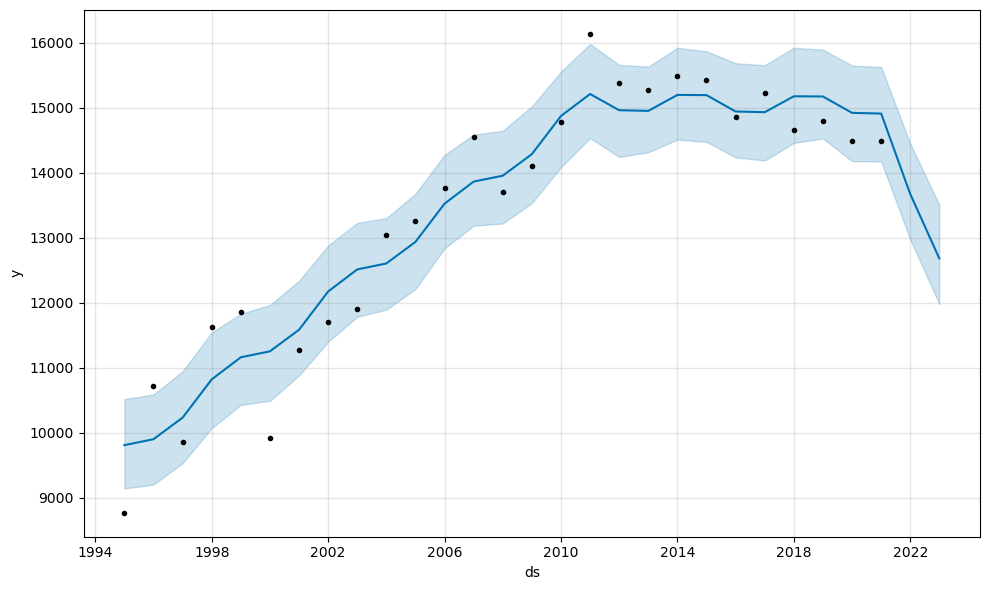

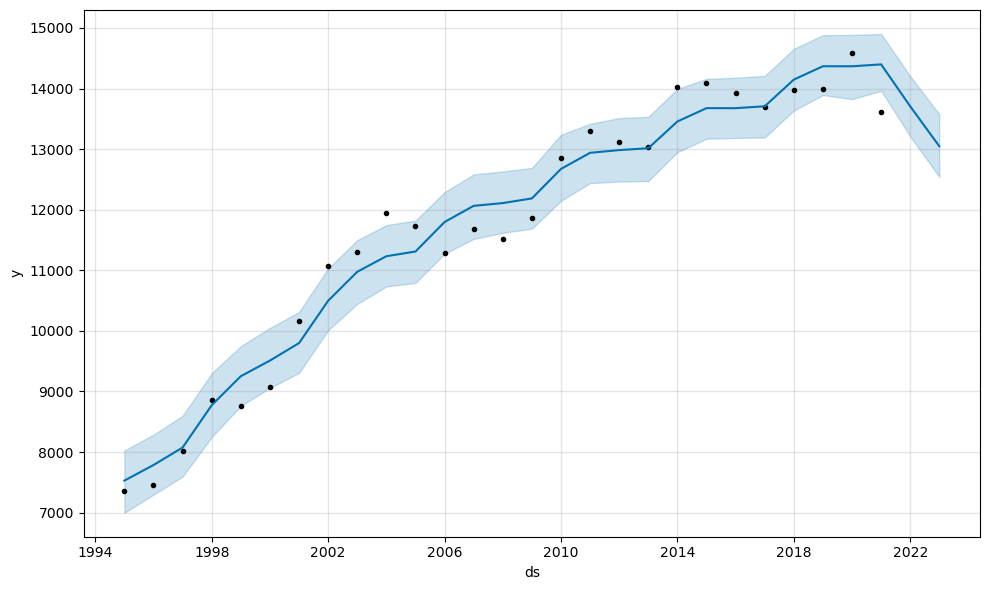

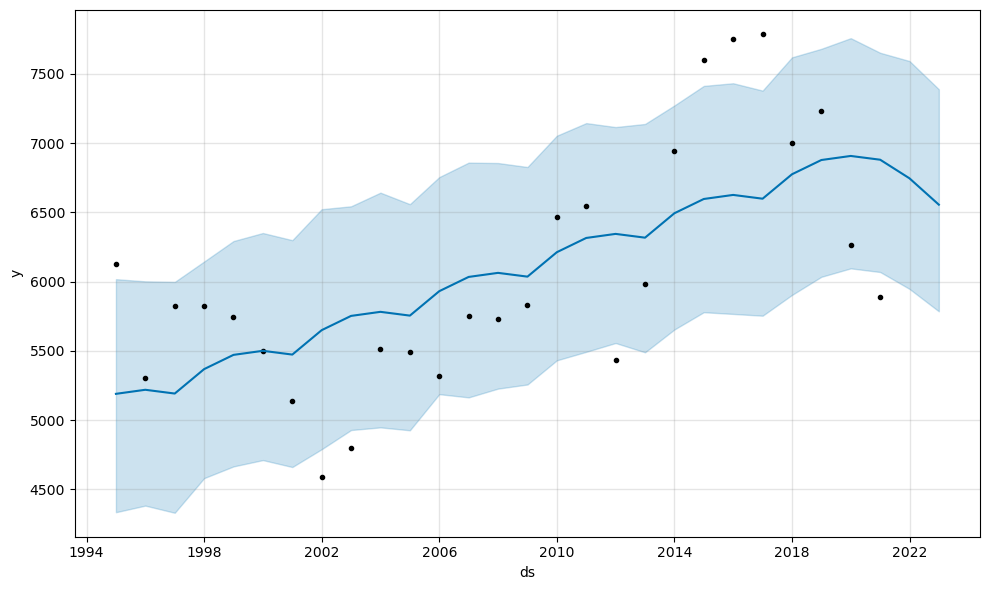

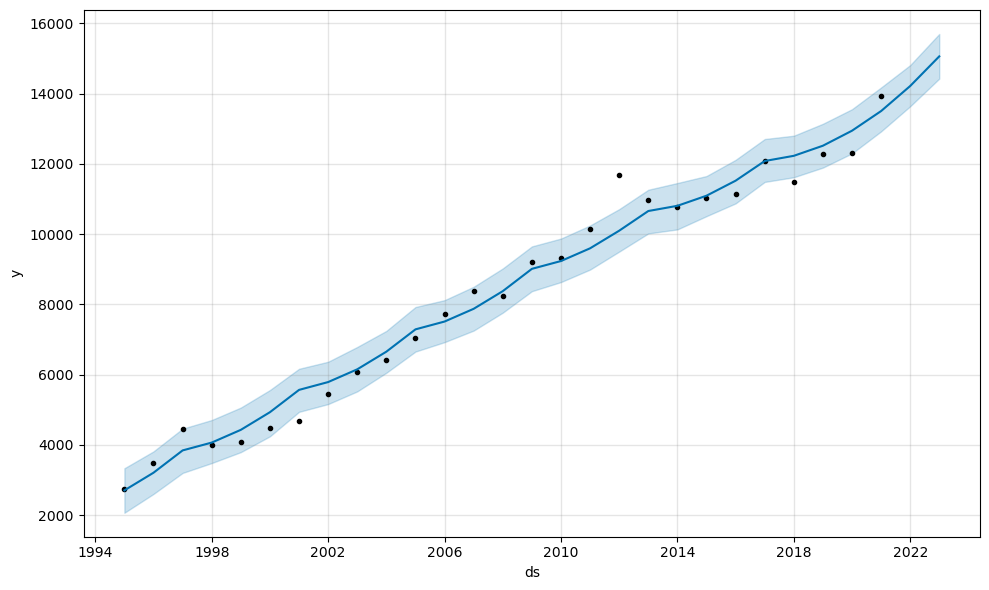

In [68]:
for el in best_imp_arr:
    df = oiv_wine_imp[oiv_wine_imp.Country == el].rename(columns={"Year": "ds", "Quantity": "y"}).drop(['Continent', 'Country', 'Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    print(el)
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=2, freq='Y')
    forecast = m.predict(future)
    fig = m.plot(forecast)

exportation

In [69]:
best_exp_arr = best_exp.Country.unique()

00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:33 - cmdstanpy - INFO - Chain [1] done processing
00:47:33 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing
00:47:34 - cmdstanpy - INFO - Chain [1] start processing
00:47:34 - cmdstanpy - INFO - Chain [1] done processing


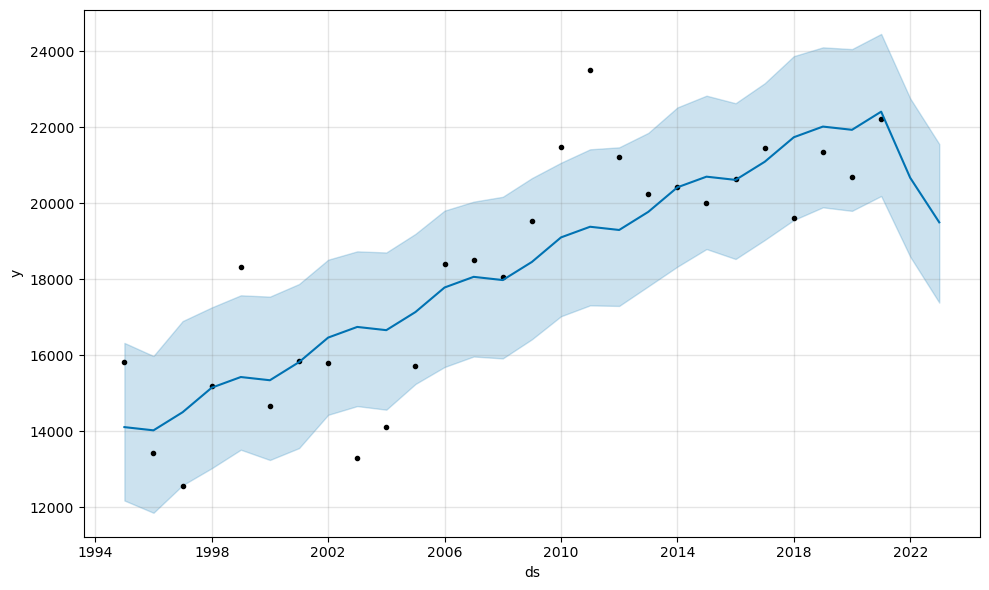

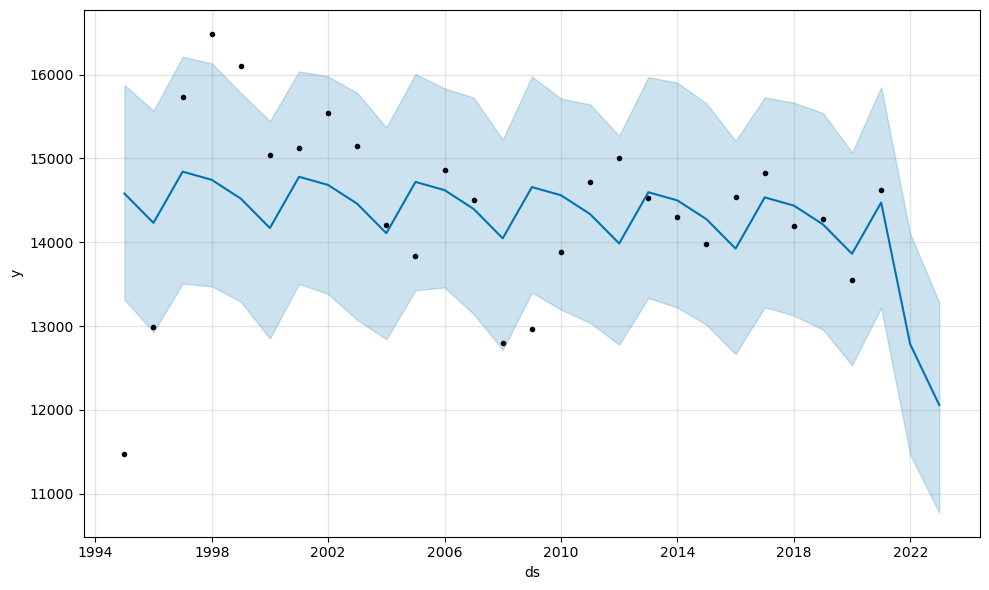

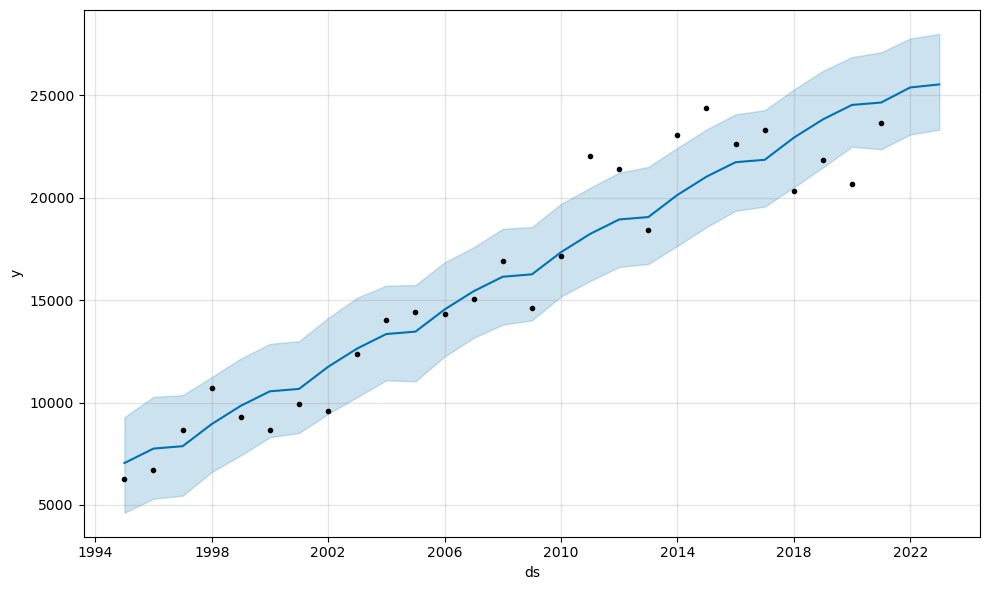

In [71]:
for el in best_exp_arr:
    df = oiv_wine_exp[oiv_wine_exp.Country == el].rename(columns={"Year": "ds", "Quantity": "y"}).drop(['Continent', 'Country', 'Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=2, freq='Y')
    forecast = m.predict(future)
    fig = m.plot(forecast)

production

In [72]:
best_prod_arr = best_prod.Country.unique()

00:47:49 - cmdstanpy - INFO - Chain [1] start processing
00:47:49 - cmdstanpy - INFO - Chain [1] done processing


Italy


00:47:49 - cmdstanpy - INFO - Chain [1] start processing
00:47:50 - cmdstanpy - INFO - Chain [1] done processing


France
Spain


00:47:50 - cmdstanpy - INFO - Chain [1] start processing
00:47:50 - cmdstanpy - INFO - Chain [1] done processing


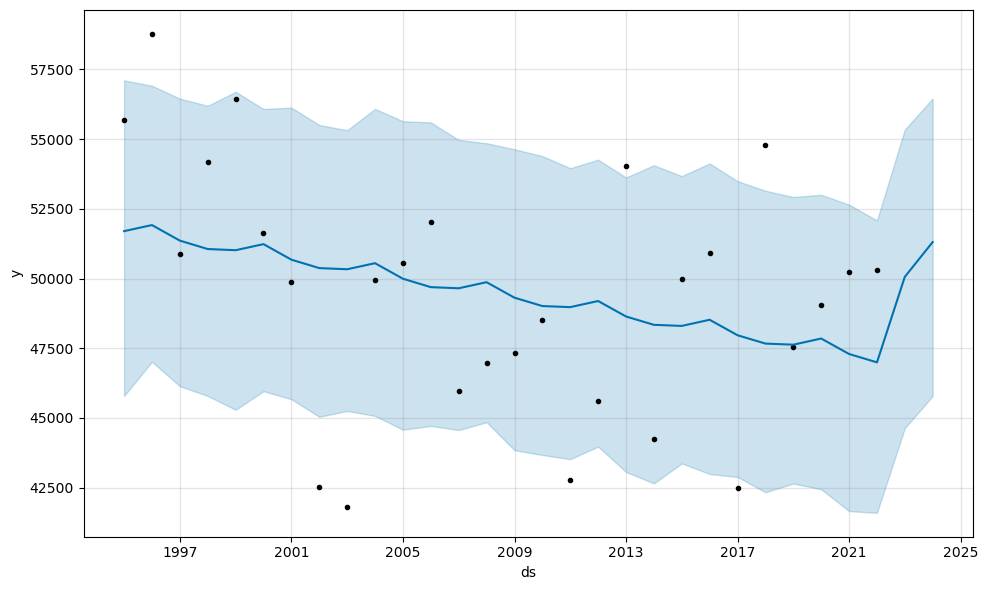

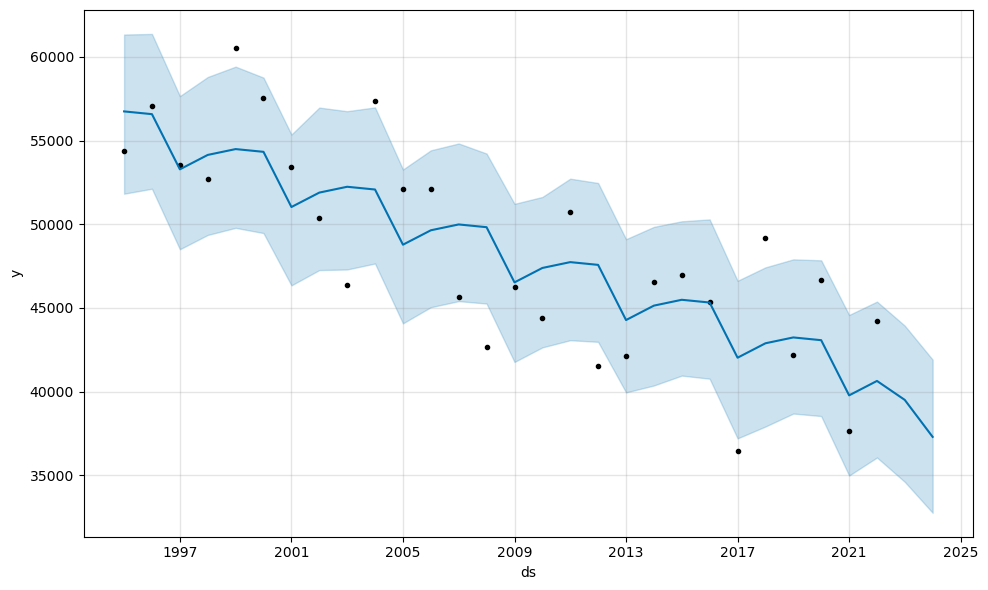

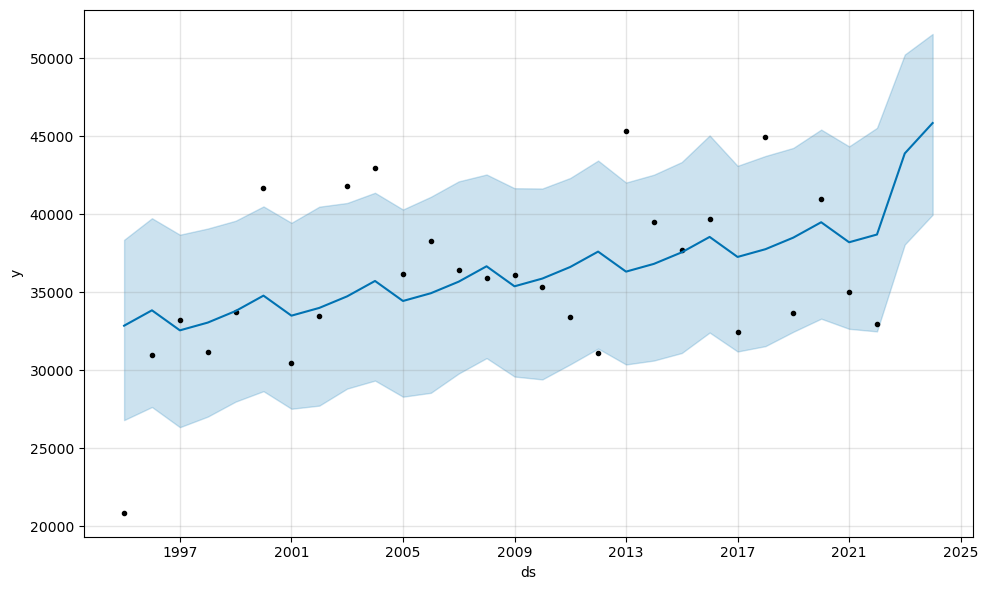

In [73]:
for el in best_prod_arr:
    df = oiv_wine_prod[oiv_wine_prod.Country == el].rename(columns={"Year": "ds", "Quantity": "y"}).drop(['Continent', 'Country', 'Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    print(el)
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=2, freq='Y')
    forecast = m.predict(future)
    fig = m.plot(forecast)

consumption

In [74]:
best_cons_arr = best_cons.Country.unique()

00:48:07 - cmdstanpy - INFO - Chain [1] start processing
00:48:07 - cmdstanpy - INFO - Chain [1] done processing


France


00:48:08 - cmdstanpy - INFO - Chain [1] start processing
00:48:08 - cmdstanpy - INFO - Chain [1] done processing


Italy


00:48:08 - cmdstanpy - INFO - Chain [1] start processing
00:48:08 - cmdstanpy - INFO - Chain [1] done processing


United States of America


00:48:08 - cmdstanpy - INFO - Chain [1] start processing
00:48:08 - cmdstanpy - INFO - Chain [1] done processing


Germany


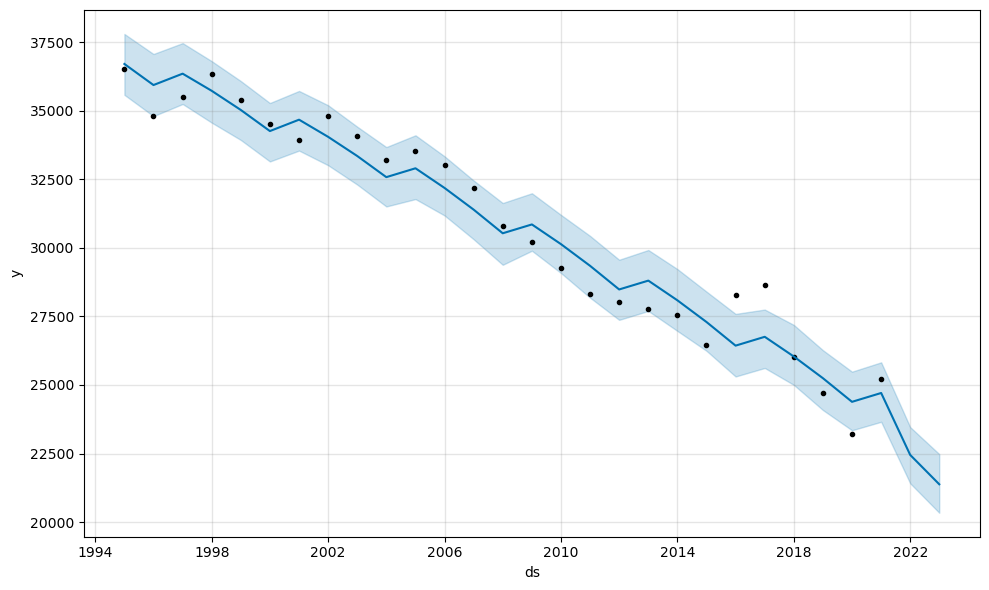

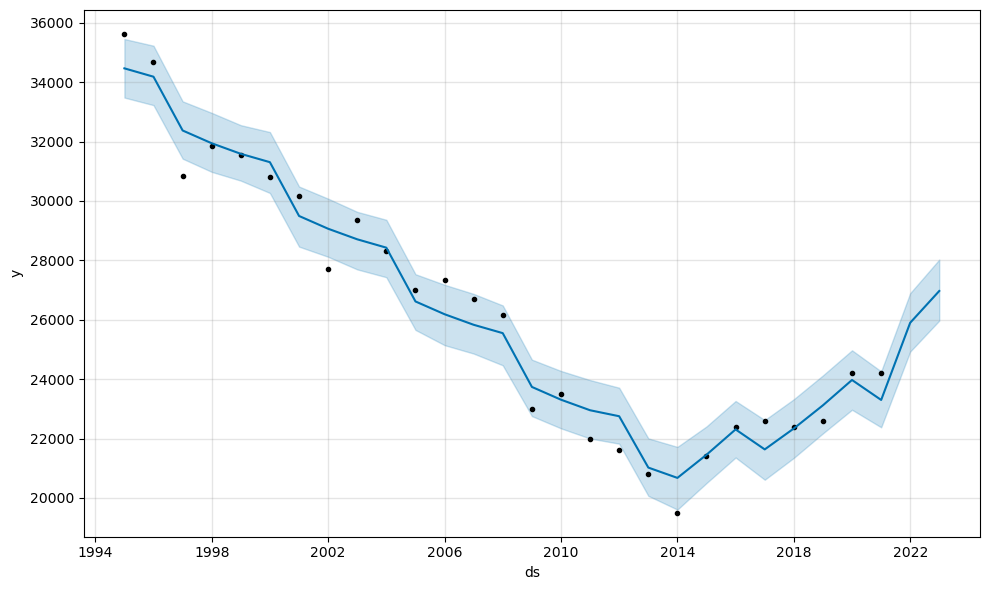

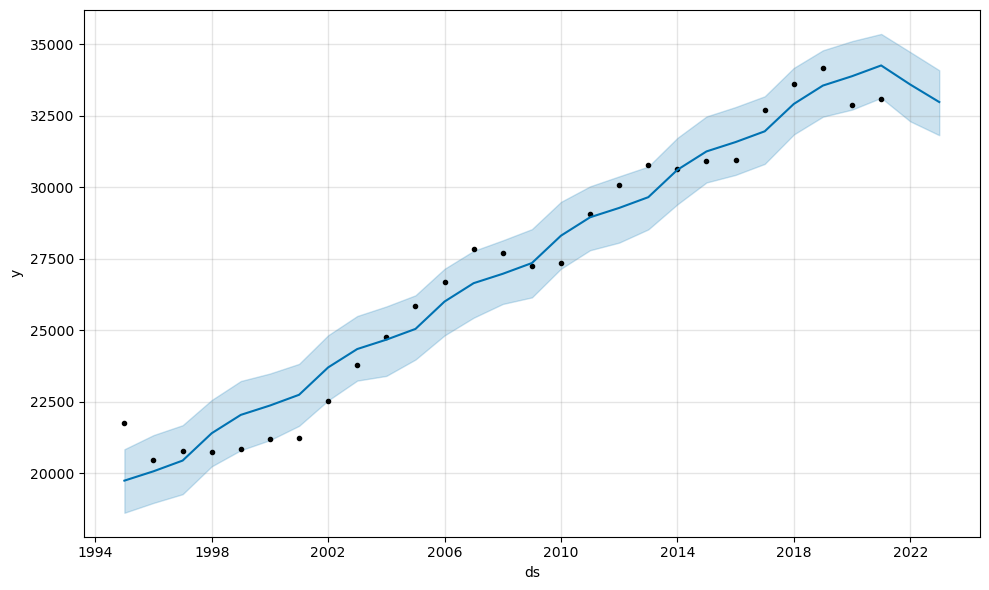

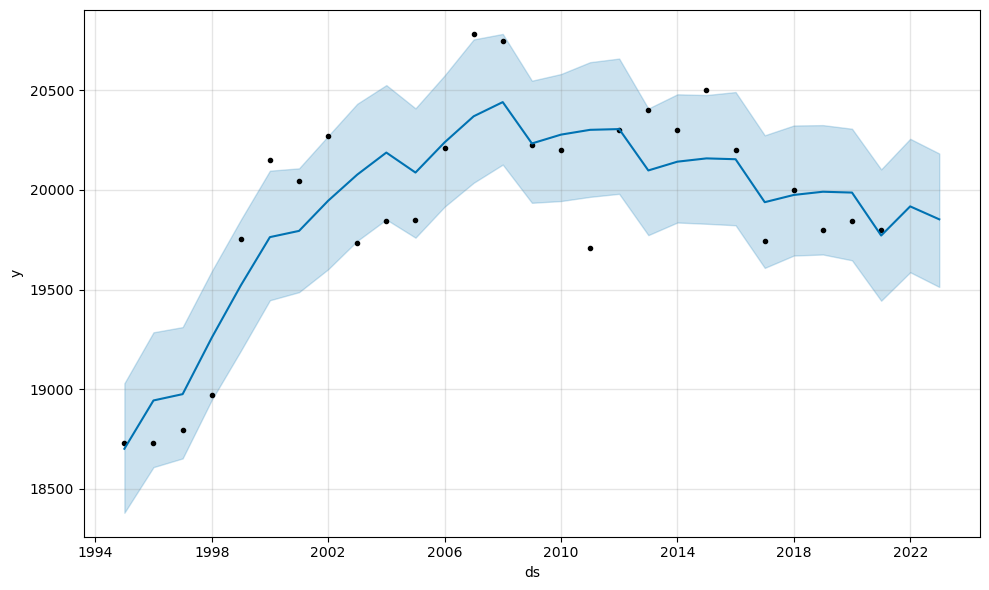

In [75]:
for el in best_cons_arr:
    df = oiv_wine_cons[oiv_wine_cons.Country == el].rename(columns={"Year": "ds", "Quantity": "y"}).drop(['Continent', 'Country', 'Product', 'Variable', 'Unit', 'Global_Quantity', 'Percent_of_global'], axis=1)
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')
    print(el)
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=2, freq='Y')
    forecast = m.predict(future)
    fig = m.plot(forecast)